<a href="https://colab.research.google.com/github/andheartsjaz/capstone_2/blob/master/capstone_2_thinkful.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Can we predict Income Level/class using Supervised Learning?**

# Capstone 2, Jaz Viccarro(Wilson), January 19, 2020
# Capstone Presentation performed on January 17, 2020

#Import the Data

In [0]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import confusion_matrix


col_names = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
             'occupation', 'relationship', 'race_ethnicity', 'gender',
             'capital_gain', 'capital_loss', 'hours_per_week', 'country_origin', 'target']

train = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=col_names, skiprows=[0])

train = train.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

print((train == '?').mean())

col_names = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
             'occupation', 'relationship', 'race_ethnicity', 'gender',
             'capital_gain', 'capital_loss', 'hours_per_week', 'country_origin', 'target']

test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', names=col_names, header=None, skiprows=[0])

cont_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
cat_cols = ['workclass','education', 'marital_status', 'occupation', 'relationship', 'race_ethnicity', 'gender','country_origin']

test = test.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

print((test == '?').mean())



#combine dfs for ease

sample = pd.concat([train, test], axis=0)
sample.head()

# drop values marked as '?'
# varied by researchers this is the best option
sample = sample[sample['workclass'] != '?']
sample = sample[sample['occupation'] != '?']
sample = sample[sample['country_origin'] != '?']
sample.shape

# After import
def stats(df):
    """Alternative that keeps the loop

    Plots each column 1 at a time and in its own plot.
    """
    stats_block = df.describe()
    print(stats_block)

    for column in df:
        df[column].hist()
        plt.title(column)
        plt.show()

stats(sample)


# Quick Data cleaning and featuring encoding/dimensioning...

In [0]:

#fix target variable column
sample['target'] = sample['target'].str.replace('<=50K.', '<=50K')
sample['target'] = sample['target'].str.replace('<=50K.', '<=50K')
sample['target'] = sample['target'].str.replace('>50K.', '>50K')
sample['target'].unique()


# encode new col for target with numeric binary
sample['target_num'] = sample['target'].copy()
sample['target_num'] = sample['target'].replace({'<=50K': 0, '>50K': 1})



# encode race/ethnicity variable
race_cats = {'White': 'E', 'Black': 'B', 'Asian-Pac-Islander': 'C', 'Amer-Indian-Eskimo': 'A','Other': 'D'}
sample['race_cats'] = sample['race_ethnicity']
sample = sample.replace({'race_cats': race_cats})
sample.head()

#create  categorical column for class 1/2
# sample.loc[sample['target'] == '<=50K', 'class_cat_1'] = 'working'
sample['class_cat_1'] = sample.loc[sample['target'] == '>50K', 'class_cat_1'] = 'middle'

sample.head(10)

sample.loc[sample['target'] == '<=50K', 'class_cat_1'] = 'working'

# debugging
print(sample['class_cat_1'].unique())
print(sample['target_num'].unique())
print(sample['target'].unique())
print(sample['race_cats'].unique())

['working' 'middle']
[0 1]
['<=50K' '>50K']
['E' 'B' 'C' 'A' 'D']


3.    Third: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.
Please execute the three tasks above in a Jupyter notebook that you will submit to the grading team below.

___________________________________

# Prediction Task: Can we use US Census data to predict class?

**Null hypothesis: 
The average age between classes is the same.**

**Alternative Hypothesis:
There is a statistically significant difference in age across classes.**

> Class Definitions:
- Working Class: income at and below 50,000(USD) annually.
- Middle Class: income above 50,000(USD) annually.

________________________________

# Significance Testing of the Independent Variable in our Hypothesis

Perforemd tests for the significance of independent variable form our null hypothesis

> H(naught)
> a = <=50K. ;
> b = >50K. 

> threshold of P <= 0.05 
_(although, researchers recommended using a more liberal threshold of 0.20 or 0.10)_<sup>1</sup> 

- Distribution is not normal on Normalcy tests,

**independent t-test and Kruskal-Walis Test for Significance.**

_We can confirm that we reject the Null hypothesis p-value being below threshold of 0.05 (p<0.05)_

> t-test _p = 0.002_

> Kruskal-Walis _p = 0.000_

In [0]:
#@title
a = sample[sample['target'] == '<=50K']
a_test = a['age'].mean() # var = 183.8736

b = sample[sample['target'] == '>50K']
b_test = b['age'].mean() # var = 106.9156

from scipy.stats import kruskal

a = sample[sample['target'] == '<=50K']
a_test = a['age'] # var = 183.8736

b = sample[sample['target'] == '>50K']
b_test = b['age'] # var = 106.9156
a_test = np.array(a_test)
b_test = np.array(b_test)

stat, p = kruskal(a_test, b_test)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

# t, p = stats.norm.rvs(a_test, b_test)
# k2, p = stats.normaltest(a_test, b_test)

from scipy import stats
t1, p1 = stats.ttest_ind(a_test, b_test)
print(f'The results of the test for normalcy is:{t1} and p = {p1}\n')
alpha = 0.10
print("p = {:g}".format(p1))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected\n")


# t test of all cont data

t, p = stats.ttest_ind(sample[sample.gender == 'Female'][['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']], 
          sample[sample.gender == 'Male'][['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])
print(t)
print(p)

# store p-values for continuous variables
p_cont_cols = [2.11471537e-68, 6.74673471e-09, 4.69677362e-01, 5.86510876e-24, 4.83111700e-23, 0.00000000e+00]

Statistics=2310.518, p=0.000
Different distributions (reject H0)
The results of the test for normalcy is:-43.314069277479774 and p = 0.0

p = 0
The null hypothesis can be rejected
[-17.50746471  -5.79821956  -0.72301019 -10.09987098  -9.8904948
 -50.58569952]
[2.11471537e-68 6.74673471e-09 4.69677362e-01 5.86510876e-24
 4.83111700e-23 0.00000000e+00]


# One last test! The Wald Test or Chi^2 

We will perform the Chi^2 test to see if the significance of our Hypothesis variable -- namely, is there significance to our hypothesis that the difference between age in the target sub-groups is significant?

## **Given our p value below being above threshold, we contend to reject our null hypothesis and treat age as a dependent variable.**

In [0]:
#@title
from sklearn.feature_selection import chi2

# help(chi2)

print(cont_cols)

X = sample[cont_cols]
y = sample['target'].values

chi2, pval = chi2(X, y)


from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(X)

print(p)



# interpret test-statistic 
# cite: https://machinelearningmastery.com/chi-squared-test-for-machine-learning/


alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
print(chi2)
print(pval)




['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
0.0
Dependent (reject H0)
[1.15527297e+04 1.57978375e+05 3.22639959e+03 1.13088730e+08
 1.85068896e+06 8.22218727e+03]
[0. 0. 0. 0. 0. 0.]


__________________________

# Model Preparation

#### _a vs. b_

> Working Class == group _a_ is our class 1, where _y= 0_ and is classified as _"<=50K"

> Middle Class == group _b_ is our class 2, where _y= 2_ and is classified as _">50K",

Given the distributions of the continous variables, we may expect to see _age_ to be a good predictor along with _education_num_ and _fnlwgt_.  

Let's confirm again with histograms.  We'd expect to scale at least one or all of these variables during model instantiation and reiteration.

In [0]:
#class 1
a.hist()
plt.tight_layout()
plt.show()

NameError: ignored

In [0]:
class #2 
b.hist()
plt.tight_layout()
plt.show();

> Given the above, we think using _age_ as a primary feature in the  Univariate Regression, and also, a good variable to use for model calibrtion. 

## EDA



Here we can illustrate the class disparities when plotting against the Target variable: 

**75.22% of the dependent varible is owned by Men.** 

**32.96% of the dependent variable comprise Women**

        n of the sample = 45,221
        - men = 34,013
        - women = 11,208



Frequencies of Gender in Target variable

0    34013
1    11208
Name: target_num, dtype: int64


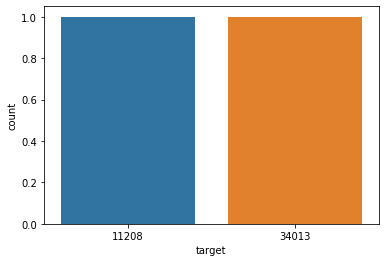

In [0]:
print(sample['target_num'].value_counts())
sns.countplot(sample['target'].value_counts())
plt.title('Frequencies')
plt.show()

Distribution - Target by Gender

Text(0.5, 1.0, 'Dsitributions')

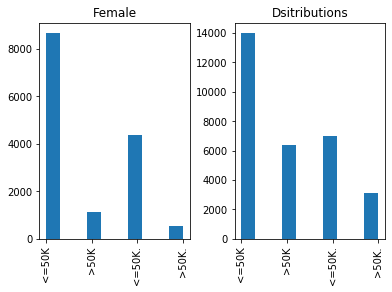

In [0]:
sample['target'].hist(by=sample['gender']);
plt.title('Dsitributions')


In [0]:
sample.boxplot(by ='target', figsize=(11,8));

In [0]:
from scipy import stats
cont_cols = 'age', 'fnlwgt', 'education_num','hours_per_week', 'cap
for column in cont_cols:
    print(stats.describe(sample[col])

Our table shows independent variable observations given the dependent variable, our Target.  The Boxplot indicates that scaling of the _fnlwgt_ variable will likely need to be transformed.  We will do this later during the modeling process.

Given our histograms and boxplots, we will likely utilize _age_ variable first, as we believe it is the most liekly to create a good baseline due to it's 

In [0]:
from scipy import stats
sample['age'].describe()
stats.describe(sample['age'])

DescribeResult(nobs=45221, minmax=(17, 90), mean=38.54793127086973, variance=174.7159522107561, skewness=0.5327946184834096, kurtosis=-0.15605102511821123)

In [0]:
sample.groupby('target_num').mean()[['age', 'fnlwgt', 'education_num','hours_per_week', 'capital_gain', 'capital_loss']]

,age,fnlwgt,education_num,hours_per_week,capital_gain,capital_loss
target_num,,,,,,
0,36.749361,190178.526475,9.630671,39.372005,148.963867,54.034016
1,44.006067,188397.967345,11.598501,45.690489,3991.791667,193.487063


Distribution of Continous Variables

In [0]:
cont_df = sample[['age', 'fnlwgt', 'education_num','hours_per_week', 'capital_gain', 'capital_loss']]
cont_cols = ['age', 'fnlwgt', 'education_num','hours_per_week', 'capital_gain', 'capital_loss']

# for-loop for continuous cols histograms
for columns in cont_df:
    cont_df[cont_cols].hist()
    plt.legend()
    plt.title('Distributions: Continuous Variable')
    plt.show()
    



Distribution Plots of the Continous Variable - Age

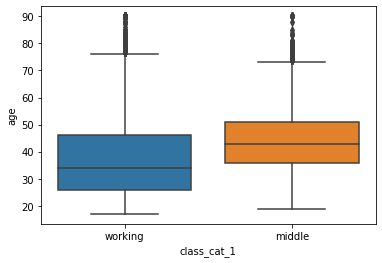

In [0]:
sns.boxplot('class_cat_1', 'age', data=sample)
plt.show()

Distibution Plots, _age_

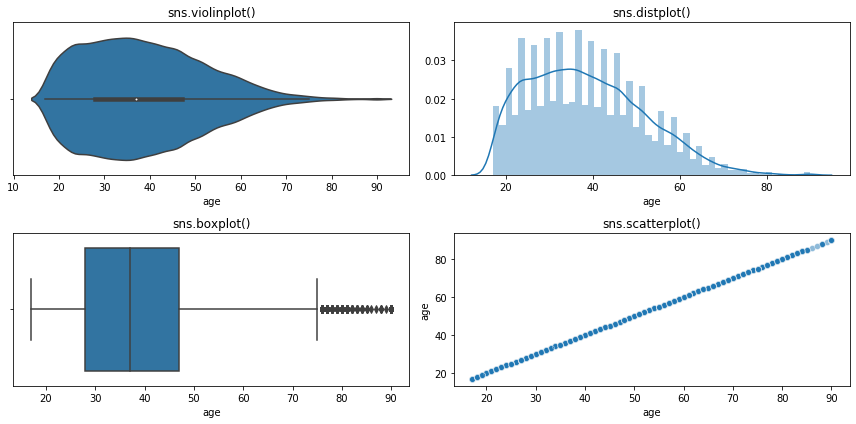

In [0]:
fig, axes = plt.subplots(2, 2, sharey=False)

sns.violinplot(sample['age'], ax=axes[0, 0]);
sns.distplot(sample['age'], ax=axes[0, 1]);
sns.boxplot(sample['age'], ax=axes[1, 0])
sns.scatterplot(sample['age'], 
                sample['age'], 
                ax=axes[1, 1],
                alpha=0.5)

axes[0, 0].set_title('sns.violinplot()')
axes[0, 1].set_title('sns.distplot()')
axes[1, 0].set_title('sns.boxplot()')
axes[1, 1].set_title('sns.scatterplot()')

fig.set_size_inches(12, 6)
fig.tight_layout()
fig.show()

Distribution Plots of the Continous Variable - fnlwgt

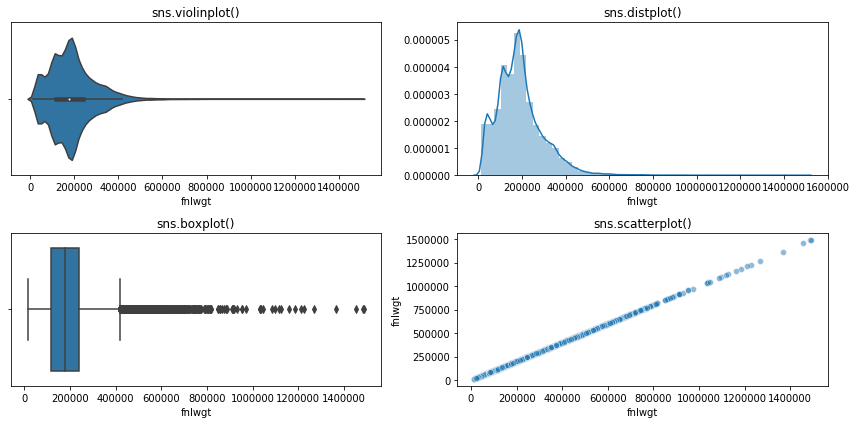

In [0]:
fig, axes = plt.subplots(2, 2, sharey=False)

sns.violinplot(sample['fnlwgt'], ax=axes[0, 0]);
sns.distplot(sample['fnlwgt'], ax=axes[0, 1]);
sns.boxplot(sample['fnlwgt'], ax=axes[1, 0])
sns.scatterplot(sample['fnlwgt'], 
                sample['fnlwgt'], 
                ax=axes[1, 1],
                alpha=0.5)

axes[0, 0].set_title('sns.violinplot()')
axes[0, 1].set_title('sns.distplot()')
axes[1, 0].set_title('sns.boxplot()')
axes[1, 1].set_title('sns.scatterplot()')

fig.set_size_inches(12, 6)
fig.tight_layout()
fig.show()

Distribution Plots of the Continous Variable - education num

In [0]:
fig, axes = plt.subplots(2, 2, sharey=False)

sns.violinplot(sample['education_num'], ax=axes[0, 0]);
sns.distplot(sample['education_num'], ax=axes[0, 1]);
sns.boxplot(sample['education_num'], ax=axes[1, 0])
sns.scatterplot(sample['education_num'], 
                sample['education_num'], 
                ax=axes[1, 1],
                alpha=0.5)

axes[0, 0].set_title('sns.violinplot()')
axes[0, 1].set_title('sns.distplot()')
axes[1, 0].set_title('sns.boxplot()')
axes[1, 1].set_title('sns.scatterplot()')

fig.set_size_inches(12, 6)
fig.tight_layout()
fig.show()

Sccatterplots of the Continuous Variables

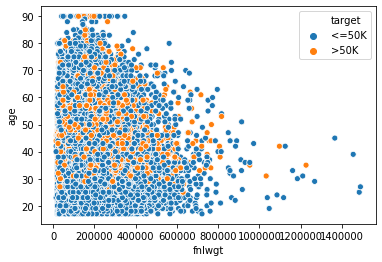

In [0]:
sns.scatterplot('fnlwgt', 
                'age',
                hue='target',
                data=sample)
plt.show()

    > Note, the the lack of linearity makes it difficult to linearly seperate..maybe affects model?

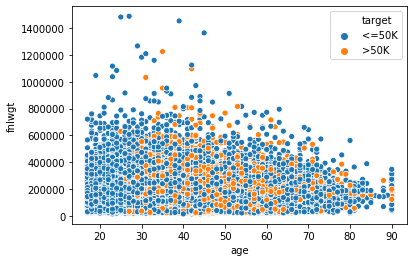

In [0]:
sns.scatterplot('age', 
                'fnlwgt',
                hue='target',
                data=sample)
plt.show()



> # The two scatter plots above show the idea behind the Logistic Regression; that in order to best classify, we need the transpose the data and allow the x axis to be the binary values for _y_, aka our _target_; _working_ or _middle_ class.



---



---



Below, is a better example of what the math is telling us to do in Logistic Regression

- try and find the best way to separate the data linearly (below, it's _Longitudely_ !)

- except! y = X<sub>x1</sub> and x = (0,1]

Let's try to use what we think would be our best first predictor value and a way to check for error---the _age_ column versus _target_num_ the column we encoded previously.

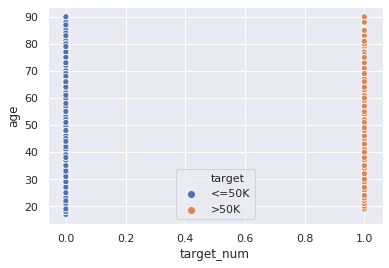

In [0]:
sns.scatterplot('target_num', 
                'age',
                hue='target',
                data=sample)
plt.show()

This scatterplot illustrates how well stratified the data should be when their probabilties sit between 0 and 1.  The semi-convex and concavity of seen as each "string" of data points are stacked on top of one another, ascending by _age_. This tells us that the _age_ column may produce too much noise in the model, which could lead it to be overfit and thus need scaling.



---



---



This scatter plot below is a great way of illustrating how the coeffecients, when turned-on by the classifier, act as "probability IDs" for the data points.  

So, to say, using _education_num as an example, we can see how logistic Regression uses the averages in the independent variable from our hypothesis to create "boundaries" and the intecept wil work as th "lift" each point gets, which is multiplied and added "bilocated" to create a "possibilities matrix" 

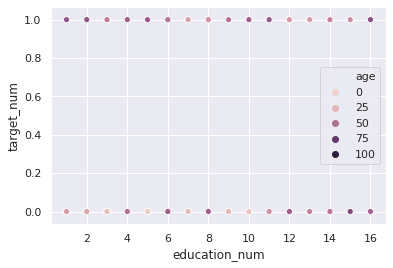

In [0]:
sns.scatterplot('education_num', 'target_num', hue='age', data=sample)
plt.show()

Lastly, for the Continous Variables, we will use a scatter plot to plot what we think the test the results of our model will be: (just de-dimensioning...)

Text(0.5, 1.0, '\n Univariate Recursion\nUsing 2d scatter plot to illustrate the prediction the accuracy of y_test')

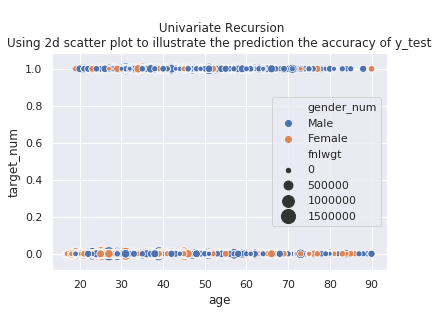

In [0]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="age", y="target_num", hue="gender_num", size="fnlwgt", sizes=(20, 200), hue_norm=(0, 7), legend="brief", data=sample)
plt.title('\n Univariate Recursion\nUsing 2d scatter plot to illustrate the prediction the accuracy of y_test')

we will use a scatter plot to plot what we think the test the results of our model will be: (just re-dimensioning...)

Text(0.5, 1.0, '\n Multivariate Regression post Recursion\nUsing 2d scatter plot to illustrate the prediction the cardinality within Random Forest Decision Trees')

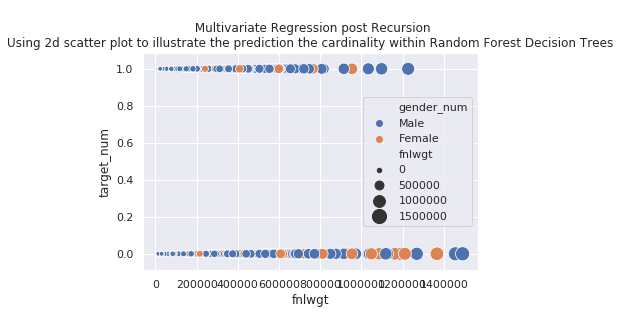

In [0]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="fnlwgt", y="target_num", hue="gender_num", size="fnlwgt", sizes=(20, 200), hue_norm=(0, 7), legend="brief", data=sample)
plt.title('\n Multivariate Regression post Recursion\nUsing 2d scatter plot to illustrate the predictions (cardinality) within Random Forest Decision Trees')

# What about our Categorical Data?

Since the categorical data will be encoded, and outside of gender, only the target is binary.  So, we don't anticipate any of these being the main feature in a Univariate Logistic Model or a "slim" Multivariate Logistic Model.

Below, we've outline 3 disparities:

- The number of observations by gender, when classed by the target shows that Men outnumber Women 2 to 1 in this sample. 

    - Due to this class imbalance we will likely note refer to gender beyond using it's ability to separate the _target_ more clearly. 

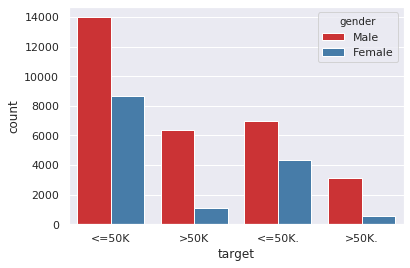

In [0]:
# class imbalance
sns.set(style="darkgrid")
ax = sns.countplot(x="target", hue='gender', data=sample, palette="Set1")

In [0]:
#encode gender
sample['gender_num'] = sample['gender_num'].replace({'male': 0, 'female': 1})

0          Male
1          Male
2          Male
3        Female
4        Female
          ...  
16275      Male
16276    Female
16278      Male
16279      Male
16280      Male
Name: gender_num, Length: 45221, dtype: object

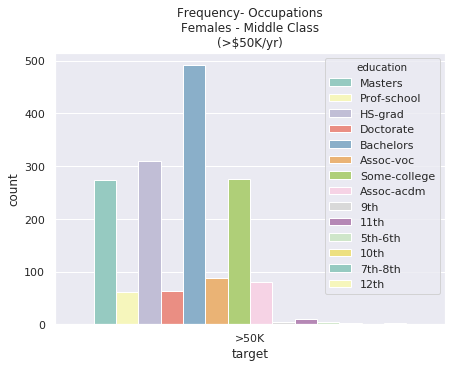

In [0]:
one = sample[sample['target'] == '>50K']
one_cleaned = one[one['gender'] == 'Female']

plt.figure(figsize=(7,5))
sns.countplot(x='target',
    hue='education',
    data=one_cleaned,
#     hue_order='relationship',
#     orient='h',
    color='cyan',
    palette='Set3',
    saturation=0.75)
plt.title('Frequency- Occupations\nFemales - Middle Class\n(>$50K/yr)')
plt.show();

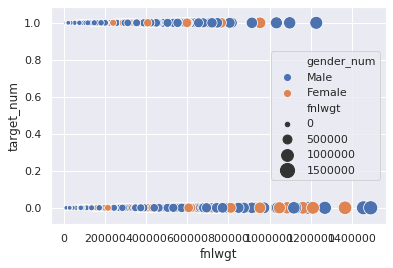

In [0]:
sns.scatterplot(x='fnlwgt', y='target_num', sizes='race_cats', date=inverse)

While numerous research facilities posited the illegitimacy of race/ethnicity in model prep, I will demonstrate this just to show the inverse relationship to _race/ethnicity_ and _fnlwgt_.


In [0]:
#inverse relationships
print(sample.groupby(['gender', 'race_cats']).mean()[['fnlwgt', 'age']].sort_values(by='fnlwgt', ascending=False))

inverse = sample[['race_cats', 'gender', 'fnlwgt', 'target']]

sns.scatterplot(x='fnlwgt', y='target_num', sizes='race_cats', date=inverse)

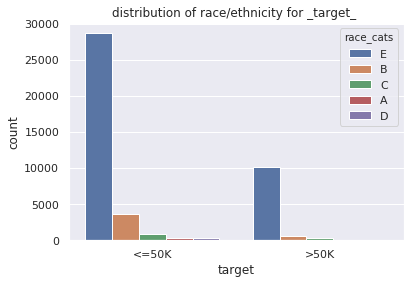

In [0]:
# frequencies of race groups 
sns.countplot('target', hue='race_cats', data=inverse)
plt.title('distribution _target_  within race/ethnicity')
plt.show()

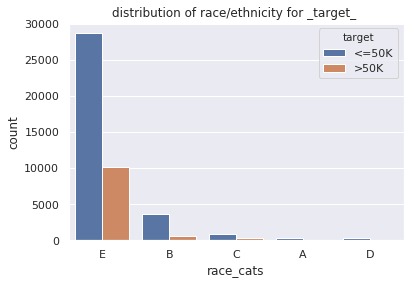

In [0]:
#frequencies of target in race groups

sns.countplot('race_cats', hue='target', data=inverse)
plt.title('distribution of race/ethnicity for _target_ ')
plt.show()

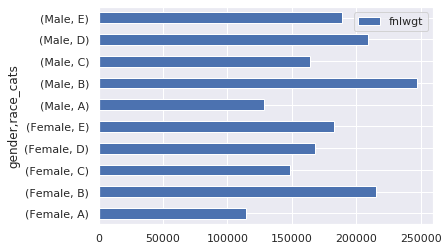

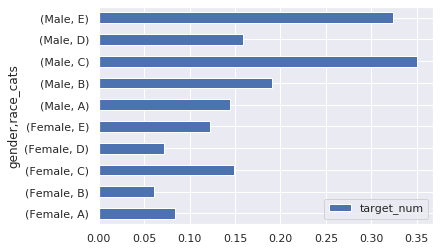

In [0]:
# by race/ethnitcity (encoded)
sample.groupby(['gender', 'race_cats']).mean()[['fnlwgt']].plot(kind='barh')
plt.show()

sample.groupby(['gender', 'race_cats']).mean()[['target_num']].plot(kind='barh')
plt.show()

sns.countplot('fnlwgt', hue='gender', data=sample)
plt.show()

Here's the last special interest group:  Ages 17-67, all above retirement age.

Where again, the feature _fnlwgt_ demonstrates it's inverse relationship to the continous variable, _age_.

                     age
gender target           
Female <=50K   35.305828
       >50K    41.490244
Male   <=50K   36.026970
       >50K    43.703636
                      fnlwgt
gender target               
Female <=50K   186230.112445
       >50K    184605.953659
Male   <=50K   193363.715810
       >50K    189492.952805


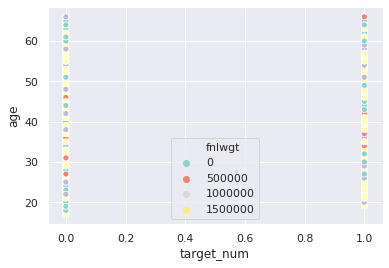

In [0]:
# Limiting by Retirement Age, 67 yrs old -- optional 
above_retirement = sample.loc[sample['age'] < 67] 
print(above_retirement.groupby(['gender', 'target']).mean()[['age']])
print(above_retirement.groupby(['gender', 'target']).mean()[['fnlwgt']])

sns.scatterplot('target_num', 'age', hue='fnlwgt', data=above_retirement, palette='Set3')

# Correalation Matrix and Indices

                     age    fnlwgt  ...  capital_gain  capital_loss
age             1.000000 -0.075792  ...      0.079683      0.059351
fnlwgt         -0.075792  1.000000  ...     -0.004107     -0.004354
education_num   0.037623 -0.041968  ...      0.126905      0.081718
hours_per_week  0.101992 -0.018681  ...      0.083881      0.054195
capital_gain    0.079683 -0.004107  ...      1.000000     -0.032102
capital_loss    0.059351 -0.004354  ...     -0.032102      1.000000

[6 rows x 6 columns]


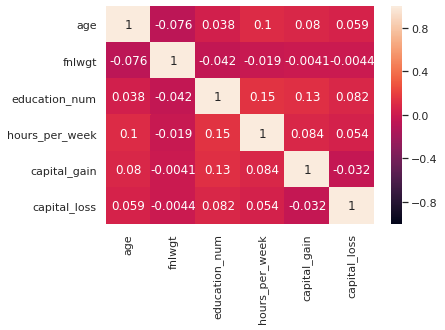

In [0]:
# Correalation Matrix and Indices

# Feature Relationships
# Heat-Map showing Feature-to-Feature and
# Feature-to-Label’s Pearson Correlation Coefficients

cont_cols = ['age', 'fnlwgt', 'education_num','hours_per_week', 'capital_gain', 'capital_loss']
corr = sample[cont_cols].corr()
sns.heatmap(corr, vmin=-1,  vmax=1, annot=True)

print(corr)

# Log-Transform of Continous Variables for correlation index
- Note: the affect positively affects our _fnlwgt_ and _educcation_num_ var.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


                     age    fnlwgt  ...  capital_gain  capital_loss
age             1.000000 -0.060448  ...      0.220994      0.099939
fnlwgt         -0.060448  1.000000  ...      0.010639      0.007688
education_num   0.030817 -0.046242  ...      0.363825      0.074802
hours_per_week  0.156274 -0.009227  ...      0.263348      0.071553
capital_gain    0.220994  0.010639  ...      1.000000           NaN
capital_loss    0.099939  0.007688  ...           NaN      1.000000

[6 rows x 6 columns]


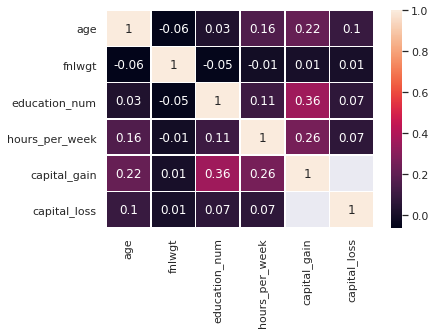

In [0]:
sns.heatmap(np.log(sample[cont_cols]).corr().round(2), annot=True, linewidths=.5);

corr_log= np.log(sample[cont_cols]).corr()
print(corr_log)

Chi^2 Test

In [0]:
from sklearn.feature_selection import chi2

# help(chi2)

X = sample[cont_cols]
y = sample['target']

chi2(X, y)

(array([1.15527297e+04, 1.57978375e+05, 3.22639959e+03, 1.13088730e+08,
        1.85068896e+06, 8.22218727e+03]), array([0., 0., 0., 0., 0., 0.]))

## Encoding Variables for the model

In [0]:
sample.columns
cat_cols



['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race_ethnicity',
 'gender',
 'country_origin']

In [0]:
# dummy the categorical columns

encoded_df = pd.concat([sample, pd.get_dummies(sample['workclass'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['education'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['marital_status'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['occupation'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['relationship'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['race_ethnicity'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['gender'], drop_first=True)], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(sample['country_origin'], drop_first=True)], axis=1)
encoded_df.drop(['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race_ethnicity', 'gender', 'country_origin', 'target_num', 'race_cats'], axis=1, inplace=True)

# Logistic Model Univariate 1,0

Accuracy of Univariate Logistic Regression: Independent Variable: Age on Test Data 0.735
Accuracy of Univariate Logistic Regression: Independent Variable: Age on Training Data: 0.740
[[0.04082544]]
              precision    recall  f1-score   support

       <=50K       0.75      0.98      0.85      6757
        >50K       0.19      0.02      0.03      2288

    accuracy                           0.73      9045
   macro avg       0.47      0.50      0.44      9045
weighted avg       0.61      0.73      0.64      9045



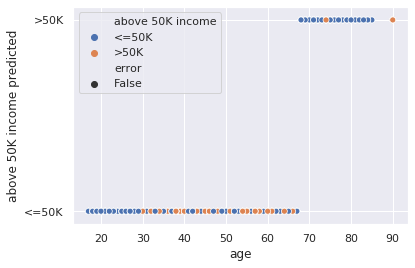

In [0]:
# Logistic Model Univariate 1,0
# 'Age' variable used as first feature for Balancing
# Come up with Expected Error #(1 - worst score)

X = encoded_df[['age']]
y = encoded_df['target']

#perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)


# instantiate the model, set max_iter to 100
lr = LogisticRegression(solver='lbfgs', max_iter=100)

# instantiate the model
lr.fit(X_train, y_train)
lr_score_age = lr.score(X_test, y_test)
lr_predictions = lr.predict(X_test)
test_score_age = lr.score(X_train, y_train)

# Print Score
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age on Test Data {:.3f}'.format(lr_score_age))
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age on Training Data: {:.3f}'.format(test_score_age))
print(lr.coef_) # probabilitiy of age given target [[0.04082544]]

#print classification
print(classification_report(y_test, lr_predictions))

#confusion matrix
confusion_df = pd.DataFrame(confusion,
                            columns=['predicted_0', 'predicted_1'],
                            index=['actual_0', 'actual_1'])
confusion_df




# make df with predictions and errors
income_df = pd.DataFrame(X_test, columns=['age'])
income_df['above 50K income'] = y_test.values
income_df['above 50K income predicted'] = lr_predictions
income_df['error'] = income_df['above 50K income predicted'] != income_df['above 50K income predicted']
income_df.head()

sns.scatterplot('age', 
                'above 50K income predicted', 
                hue='above 50K income',
                style='error',
                data=income_df)
plt.show()


# Logistic Model Univariate 1,1

Accuracy of Univariate Logistic Regression: Independent Variable: Age (Scaled) on Test Data  0.735
Accuracy of Univariate Logistic Regression: Independent Variable: Age (scaled) on Training Data: 0.740
[[2.95244955]]
              precision    recall  f1-score   support

       <=50K       0.75      0.98      0.85      6757
        >50K       0.19      0.02      0.03      2288

    accuracy                           0.73      9045
   macro avg       0.47      0.50      0.44      9045
weighted avg       0.61      0.73      0.64      9045



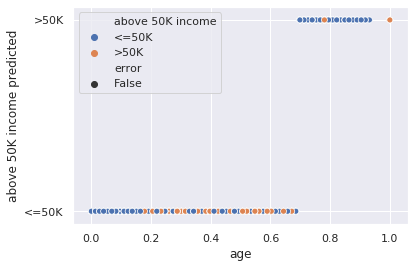

In [0]:
# Logistic Model Univariate 1,1
# maybe using scaled data will yield better results
#Perform on Scaled Data, use MinMax Scalar


X = encoded_df[['age']]
y = encoded_df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)

 # # scaler = StandardScaler()
scaler = MinMaxScaler()
# # scaler = None
if scaler is not None:
    scaler.fit_transform(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)                                       


# instantiate the model, set max_iter to 1000, penalty of l2 and 'C' at 0.5
lr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=0.5)

# fit the model
lr.fit(X_train, y_train)
lr_score_scaled = lr.score(X_test, y_test)
lr_predictions_scaled = lr.predict(X_test)
test_score_scaled = lr.score(X_train, y_train)

#Print Scores
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age (Scaled) on Test Data  {:.3f}'.format(lr_score_scaled))
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age (scaled) on Training Data: {:.3f}'.format(test_score_scaled)) #overfit?

# print(lr_predictions_scaled)
scaled_lr_pred = pd.Series(lr_predictions_scaled)
print(lr.coef_) #[[2.95244955]]

#print
#print classification
print(classification_report(y_test, lr_predictions))

#confusion matrix
confusion_df = pd.DataFrame(confusion,
                            columns=['predicted_0', 'predicted_1'],
                            index=['actual_0', 'actual_1'])
confusion_df




# make df with predictions and errors
income_df = pd.DataFrame(X_test, columns=['age'])
income_df['above 50K income'] = y_test.values
income_df['above 50K income predicted'] = lr_predictions
income_df['error'] = income_df['above 50K income predicted'] != income_df['above 50K income predicted']
income_df.head()

sns.scatterplot('age', 
                'above 50K income predicted', 
                hue='above 50K income',
                style='error',
                data=income_df)
plt.show()


# Logistic Model Univariate 1,2

Accuracy of Univariate Logistic Regression: Independent Variable: Final Weight (MinMax-Scaled) on Test Data  0.747
Accuracy of Univariate Logistic Regression: Independent Variable: Final Weight (MinMax-Scaled) on Training Data: 0.753
0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
9040    <=50K
9041    <=50K
9042    <=50K
9043    <=50K
9044    <=50K
Length: 9045, dtype: object
[[-0.17391643]]
              precision    recall  f1-score   support

       <=50K       0.75      0.98      0.85      6757
        >50K       0.19      0.02      0.03      2288

    accuracy                           0.73      9045
   macro avg       0.47      0.50      0.44      9045
weighted avg       0.61      0.73      0.64      9045



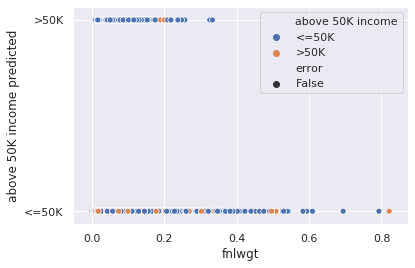

In [0]:
# Logistic Model Univariate 1,2
# 'Fnlwgt' variable used as first feature
# scale using MinMax

X = encoded_df[['fnlwgt']]
y = encoded_df['target']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)

#apply scalling
#scaler = StandardScaler()
scaler = MinMaxScaler()
# # scaler = None
if scaler is not None:
    scaler.fit_transform(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


#instantiate model with new scaled data, set max_iter to 1000, penalty of l2 and 'C' at 0.5
lr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=0.5)

#fit model and produce predictions, score
lr.fit(X_train, y_train)
lr_score_scaled = lr.score(X_test, y_test)
lr_predictions_scaled = lr.predict(X_test)
test_score_scaled = lr.score(X_train, y_train)

#pritn results 
print('Accuracy of Univariate Logistic Regression: Independent Variable: Final Weight (MinMax-Scaled) on Test Data  {:.3f}'.format(lr_score_scaled))
print('Accuracy of Univariate Logistic Regression: Independent Variable: Final Weight (MinMax-Scaled) on Training Data: {:.3f}'.format(test_score_scaled)) #overfit/under?

# print(lr_predictions_scaled)
lr_predictions_scaled = pd.Series(lr_predictions_scaled)
print(lr_predictions_scaled)

#print coefficient
print(lr.coef_) #[[-0.17391643]]
#print classification
print(classification_report(y_test, lr_predictions))

#confusion matrix
confusion_df = pd.DataFrame(confusion,
                            columns=['predicted_0', 'predicted_1'],
                            index=['actual_0', 'actual_1'])
confusion_df




# make df with predictions and errors
income_df = pd.DataFrame(X_test, columns=['fnlwgt'])
income_df['above 50K income'] = y_test.values
income_df['above 50K income predicted'] = lr_predictions
income_df['error'] = income_df['above 50K income predicted'] != income_df['above 50K income predicted']
income_df.head()

sns.scatterplot('fnlwgt', 
                'above 50K income predicted', 
                hue='above 50K income',
                style='error',
                data=income_df)
plt.show()


# Logistic Model Univariate 1,2



In [0]:
# Logistic Model Univariate 1,2
# return one iteration of 'Age', with its values scaled using Standard Scalar, and
# fit to a Random Forest Classifier to assess feature importance

scaler = StandardScaler() 
scaled_age = scaler.fit_transform(sample['age'])

print(scaled_age.describe()) # return new distribution with new scalar

#assign 'Age' vars scaled to new col in df 
sample['age_scaled_standard'] = scaled_age.values
print(sample['age_scaled'])


# define independent vars with cols from scaled df
X = sample[['age_scaled_standard']]
y = sample['target']

#train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)

#instantiate model with new scaled data, set max_iter to 1000, penalty of l2 and 'C' at 0.5
lr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=0.5)
#print coefficient
print(lr.coef_) #[[-0.17391643]]


# Model 1,4
#instantiate Random Forest Model to compare accuracy vs. importance
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)
rfc.score(X_test, y_test)
age_sscaled_feat_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(f'Here is the percentage for Feature importance for Continuous Variable: Age, using Standard Scaled Data \n:{(age_sscaled_feat_importance * 100)}')
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age (Standard Scaled) on Test Data  {:.3f}'.format(lr_score_scaled))
print('Accuracy of Univariate Logistic Regression: Independent Variable: Age (Standard Scaled) on Training Data: {:.3f}'.format(test_score_scaled)) #overfit by 5 bases points

# print(lr_predictions_scaled)
scaled_lr_pred = pd.Series(lr_predictions_scaled)
print(scaled_lr_pred)



# Multivariate Logistic Regression Model 2.1 & 2.2 / Multiclassifier Random Forest Model

In [0]:
# Model 2.1 & 2.2
# run multivariate model using both Standard Scale
# Compare features using Randfom Forest

scaler = StandardScaler() 
scaled_cont_cols = scaler.fit_transform(sample[cont_cols])
cont_cols_standard_scaled_df = pd.DataFrame(scaled_cont_cols, columns= ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'])
print(cont_cols_standard_scaled_df.describe())

# define independent vars with cols from scaled df
X = cont_cols_standard_scaled_df[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']]
y = sample['target']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)


from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)
rfc.score(X_test, y_test)
cont_cols_scaled_feat_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(f'Here is the percentage for Feature importance for Continuous Variables, using Scaled Data \n:{(cont_cols_scaled_feat_importance * 100)}')

# Multivariate Logistic Regression Model 2.3 & 2.4 / Multiclassifier Random Forest Model

In [0]:
# Model 2.3 & 2.4
# run multivariate model using MinMax()scaler
# Compare features using Randfom Forest

scaler = MinMax() 
scaled_cont_cols_mm = scaler.fit_transform(sample[cont_cols])
cont_cols_mm_scaled_df = pd.DataFrame(scaled_cont_cols_mm, columns= ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'])
print(cont_cols_mm_scaled_df.describe())

# define independent vars with cols from scaled df
X = cont_cols_mm_scaled_df[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']]
y = sample['target']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=42)

#instantiate model with new scaled data, set max_iter to 100 and 'C' at 0.3
lr = LogisticRegression(solver='lbfgs', max_iter=100, C=0.3)

#fit model and produce predictions, score
lr.fit(X_train, y_train)
lr_score_multi_mm_scaled = lr.score(X_test, y_test)
lr_multi_predictions_mm_scaled = lr.predict(X_test)
multi_test_score_mm_scaled = lr.score(X_train, y_train)

#pritn Multivariate Scores 
print('Accuracy of Multivariate Logistic Regression(MinMax-Scaled) on Test Data  {:.3f}'.format(lr_score_multi_mm_scaled))
print('Accuracy of Univariate Logistic Regression: Independent Variable: Final Weight (MinMax-Scaled) on Training Data: {:.3f}'.format(multi_test_score_mm_scaled)) #overfit/under?

# print(lr_predictions_scaled for Multivariate Model)
multi_mm_scaled_lr_pred = pd.Series(lr_multi_predictions_mm_scaled)
print(multi_mm_scaled_lr_pred)
#print coefficient
print(lr.coef_) #[[-0.17391643]]

# instantiate Random Forest with MinMax Scaled X vars
# Compare Feature importances using Multivariate vs Univariate
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)
rfc.score(X_test, y_test)
cont_cols_mm_scaled_feat_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(f'Here is the percentage for Feature importance for all Continuous Variables, using MinMax Scaled Data \n:{(cont_cols_mm_scaled_feat_importance * 100)}')


predictions = lr.predict(X_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

# Plotting the Results

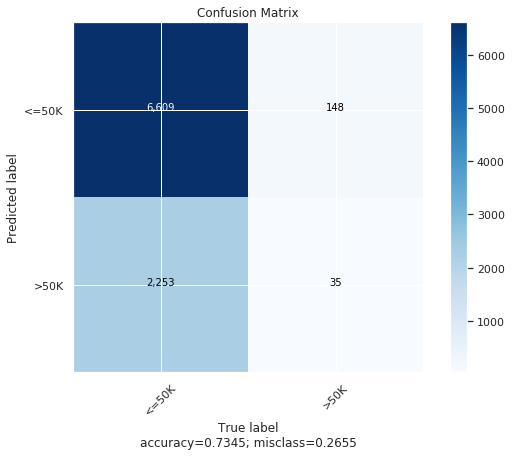

In [0]:
#@title
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(cm=confusion, target_names = ['<=50K', '>50K'], title = 'Confusion Matrix',normalize=False)


# Conclusion

 Experiment:

 - Successful ability in prediction task using 2 regression model types and a decision tree

 - robust in it's longitude, however, fell short (recall scores were very high)

 - Very high reproducibility

 - Replicated research-level faciility results in less than 4 days
 

 Model-specifics:

 - class imbalance had a great effect on our model(s)

 - great exercise for the Canon, however, costly if not careful/prepare for regression task programming
 
 - high technical debt (memory, RAM, stats vs. computer vs. engineering)

 - high extrapolation profits led to mismanaged framework of study due to restriction of reasources

Bussiness Use-cases?
 - healthcare (these types of models used in diagnostics for cancer)
 
 -  Capital markets/management (think, complexes, airports, etc...)

 - market- research

 - finance and real estate

Citations:

1 'Common pitfalls in statistical analysis: Logistic regression', Priya Ranganathan, C. S. Pramesh, and Rakesh Aggarwal, (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/)

Reference:

"A discussion of calibration techniques for evaluating binary and categorical predictive models."
Fenlon C1, O'Grady L2, Doherty ML2, Dunnion J3.
(https://www.ncbi.nlm.nih.gov/pubmed/29290291)

"Predicting Good Probabilities With Supervised Learning"
Niculescu-Mizil, Alexandru; Caruana, Rich
Department Of Computer Science, Cornell University, Ithaca NY 14853
(https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)